# 丘脑神经元模型的构建与电活动模拟

本实例将基于 `braincell` 框架实现丘脑神经元模型，包括四种典型丘脑神经元类型： `HTC`、`RTC`、`IN`、`TRN`。
通过构建这些包含复杂离子通道组合的神经元模型，你将学习如何模拟丘脑神经元的电生理特性，理解不同神经元类型的通道组成差异及其功能意义。

## 准备工作
首先确保已安装必要的库（`braincell`、`brainstate`、`brainunit`、`matplotlib`），并导入所需模块：

In [2]:
import time  # 用于记录模拟耗时

import brainstate
import braintools
import brainunit as u
import matplotlib.pyplot as plt
import braincell

## 代码详解

### 丘脑神经元基类

定义所有丘脑神经元的基类，封装通用功能：

In [3]:
class ThalamusNeuron(braincell.SingleCompartment):
    def compute_derivative(self, x=0. * u.nA):
        # 导数计算方法
        return super().compute_derivative(x * self.area)

    def step_run(self, t, inp):
        # 定义每个时间的更新规则
        with brainstate.environ.context(t=t):
            self.update(inp)
            return self.V.value

### 四种丘脑神经元类型的实现

在丘脑中，不同神经元类型通过特定的离子通道组合实现不同功能。以下分别解析其通道组成：

#### HTC

In [4]:
class HTC(ThalamusNeuron):
    def __init__(
        self,
        size,
        gKL=0.01 * (u.mS / u.cm **2),  # 钾漏通道电导
        V_initializer=brainstate.init.Constant(-65. * u.mV),  # 初始膜电位
        solver: str = 'ind_exp_euler'  # 积分方法
    ):
        super().__init__(size, V_initializer=V_initializer, V_th=20. * u.mV, solver=solver)

        # 膜面积参数
        self.area = 1e-3 / (2.9e-4 * u.cm** 2)

        # 钠离子通道
        self.na = braincell.ion.SodiumFixed(size, E=50. * u.mV)  # 钠反转电位 50 mV
        self.na.add(INa=braincell.channel.INa_Ba2002(size, V_sh=-30 * u.mV))

        # 钾离子通道
        self.k = braincell.ion.PotassiumFixed(size, E=-90. * u.mV)  # 钾反转电位 -90 mV
        self.k.add(IKL=braincell.channel.IK_Leak(size, g_max=gKL))  # 钾漏电流
        self.k.add(IDR=braincell.channel.IKDR_Ba2002(size, V_sh=-30. * u.mV, phi=0.25))  # 延迟整流钾电流

        # 钙离子通道
        self.ca = braincell.ion.CalciumDetailed(
            size,
            C_rest=5e-5 * u.mM,  # 静息钙浓度
            tau=10. * u.ms,  # 钙浓度衰减时间常数
            d=0.5 * u.um  # 钙扩散距离
        )
        self.ca.add(ICaL=braincell.channel.ICaL_IS2008(size, g_max=0.5 * (u.mS / u.cm **2)))  # L型钙通道
        self.ca.add(ICaN=braincell.channel.ICaN_IS2008(size, g_max=0.5 * (u.mS / u.cm** 2)))  # N型钙通道
        self.ca.add(ICaT=braincell.channel.ICaT_HM1992(size, g_max=2.1 * (u.mS / u.cm **2)))  # T型钙通道（低阈值）
        self.ca.add(ICaHT=braincell.channel.ICaHT_HM1992(size, g_max=3.0 * (u.mS / u.cm** 2)))  # 高阈值钙通道

        # 钙激活钾通道（IAHP）
        self.kca = braincell.MixIons(self.k, self.ca)  # 混合钾离子和钙离子
        self.kca.add(IAHP=braincell.channel.IAHP_De1994(size, g_max=0.3 * (u.mS / u.cm **2)))

        # 超极化激活阳离子电流（Ih）和漏电流（IL）
        self.Ih = braincell.channel.Ih_HM1992(size, g_max=0.01 * (u.mS / u.cm** 2), E=-43 * u.mV)  # 调节静息电位和节律
        self.IL = braincell.channel.IL(size, g_max=0.0075 * (u.mS / u.cm **2), E=-70 * u.mV)  # 背景漏电流

#### RTC

In [5]:
class RTC(ThalamusNeuron):
    def __init__(
        self,
        size,
        gKL=0.01 * (u.mS / u.cm** 2),
        V_initializer=brainstate.init.Constant(-65. * u.mV),
        solver: str = 'ind_exp_euler'
    ):
        super().__init__(size, V_initializer=V_initializer, V_th=20 * u.mV, solver=solver)

        self.area = 1e-3 / (2.9e-4 * u.cm **2)  # 膜面积参数

        # 钠离子通道
        self.na = braincell.ion.SodiumFixed(size)
        self.na.add(INa=braincell.channel.INa_Ba2002(size, V_sh=-40 * u.mV))

        # 钾离子通道
        self.k = braincell.ion.PotassiumFixed(size, E=-90. * u.mV)
        self.k.add(IDR=braincell.channel.IKDR_Ba2002(size, V_sh=-40 * u.mV, phi=0.25))  # 门控偏移
        self.k.add(IKL=braincell.channel.IK_Leak(size, g_max=gKL))

        # 钙离子通道
        self.ca = braincell.ion.CalciumDetailed(size, C_rest=5e-5 * u.mM, tau=10. * u.ms, d=0.5 * u.um)
        self.ca.add(ICaL=braincell.channel.ICaL_IS2008(size, g_max=0.3 * (u.mS / u.cm** 2)))
        self.ca.add(ICaN=braincell.channel.ICaN_IS2008(size, g_max=0.6 * (u.mS / u.cm **2)))
        self.ca.add(ICaT=braincell.channel.ICaT_HM1992(size, g_max=2.1 * (u.mS / u.cm** 2)))
        self.ca.add(ICaHT=braincell.channel.ICaHT_HM1992(size, g_max=0.6 * (u.mS / u.cm **2)))

        # 钙激活钾通道（IAHP）
        self.kca = braincell.MixIons(self.k, self.ca)
        self.kca.add(IAHP=braincell.channel.IAHP_De1994(size, g_max=0.1 * (u.mS / u.cm** 2)))

        # Ih 和 IL 电流
        self.Ih = braincell.channel.Ih_HM1992(size, g_max=0.01 * (u.mS / u.cm **2), E=-43 * u.mV)
        self.IL = braincell.channel.IL(size, g_max=0.0075 * (u.mS / u.cm** 2), E=-70 * u.mV)

#### IN

In [6]:
class IN(ThalamusNeuron):
    def __init__(
        self,
        size,
        gKL=0.01 * (u.mS / u.cm **2),
        V_initializer=brainstate.init.Constant(-70. * u.mV),  # 初始膜电位更负
        solver: str = 'ind_exp_euler'
    ):
        super().__init__(size, V_initializer=V_initializer, V_th=20. * u.mV, solver=solver)

        self.area = 1e-3 / (1.7e-4 * u.cm** 2)

        # 钠离子通道
        self.na = braincell.ion.SodiumFixed(size)
        self.na.add(INa=braincell.channel.INa_Ba2002(size, V_sh=-30 * u.mV))

        # 钾离子通道
        self.k = braincell.ion.PotassiumFixed(size, E=-90. * u.mV)
        self.k.add(IDR=braincell.channel.IKDR_Ba2002(size, V_sh=-30 * u.mV, phi=0.25))
        self.k.add(IKL=braincell.channel.IK_Leak(size, g_max=gKL))

        # 钙离子通道
        self.ca = braincell.ion.CalciumDetailed(size, C_rest=5e-5 * u.mM, tau=10. * u.ms, d=0.5 * u.um)
        self.ca.add(ICaN=braincell.channel.ICaN_IS2008(size, g_max=0.1 * (u.mS / u.cm **2)))
        self.ca.add(ICaHT=braincell.channel.ICaHT_HM1992(size, g_max=2.5 * (u.mS / u.cm** 2)))

        # 钙激活钾通道（IAHP）
        self.kca = braincell.MixIons(self.k, self.ca)
        self.kca.add(IAHP=braincell.channel.IAHP_De1994(size, g_max=0.2 * (u.mS / u.cm **2)))

        # 漏电流（IL）和 Ih 电流
        self.IL = braincell.channel.IL(size, g_max=0.0075 * (u.mS / u.cm** 2), E=-60 * u.mV)
        self.Ih = braincell.channel.Ih_HM1992(size, g_max=0.05 * (u.mS / u.cm **2), E=-43 * u.mV)

#### TRN

In [7]:
class TRN(ThalamusNeuron):
    def __init__(
        self,
        size,
        gKL=0.01 * (u.mS / u.cm** 2),
        V_initializer=brainstate.init.Constant(-70. * u.mV),
        gl=0.0075,  # 漏通道电导系数
        solver: str = 'ind_exp_euler'
    ):
        super().__init__(size, V_initializer=V_initializer, V_th=20. * u.mV, solver=solver)

        self.area = 1e-3 / (1.43e-4 * u.cm **2)

        # 钠离子通道
        self.na = braincell.ion.SodiumFixed(size)
        self.na.add(INa=braincell.channel.INa_Ba2002(size, V_sh=-40 * u.mV))

        # 钾离子通道
        self.k = braincell.ion.PotassiumFixed(size, E=-90. * u.mV)
        self.k.add(IDR=braincell.channel.IKDR_Ba2002(size, V_sh=-40 * u.mV))
        self.k.add(IKL=braincell.channel.IK_Leak(size, g_max=gKL))

        # 钙离子通道
        self.ca = braincell.ion.CalciumDetailed(size, C_rest=5e-5 * u.mM, tau=100. * u.ms, d=0.5 * u.um)
        self.ca.add(ICaN=braincell.channel.ICaN_IS2008(size, g_max=0.2 * (u.mS / u.cm** 2)))
        self.ca.add(ICaT=braincell.channel.ICaT_HP1992(size, g_max=1.3 * (u.mS / u.cm **2)))

        # 钙激活钾通道（IAHP）
        self.kca = braincell.MixIons(self.k, self.ca)
        self.kca.add(IAHP=braincell.channel.IAHP_De1994(size, g_max=0.2 * (u.mS / u.cm** 2)))

        # 漏电流（IL）
        self.IL = braincell.channel.IL(size, g_max=gl * (u.mS / u.cm **2), E=-60 * u.mV)

### 模拟丘脑神经元电活动

定义 `try_trn_neuron` 函数，设置输入电流、模拟参数，运行仿真并可视化结果：

模拟耗时：1.2333 秒


D:\Document\PyCharm\Project\braincell\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 33180 (\N{CJK UNIFIED IDEOGRAPH-819C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Document\PyCharm\Project\braincell\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30005 (\N{CJK UNIFIED IDEOGRAPH-7535}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Document\PyCharm\Project\braincell\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20301 (\N{CJK UNIFIED IDEOGRAPH-4F4D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Document\PyCharm\Project\braincell\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Document\PyCharm\Project\braincell\.venv\Lib\site-packages\IPython\core\pylabtools.py

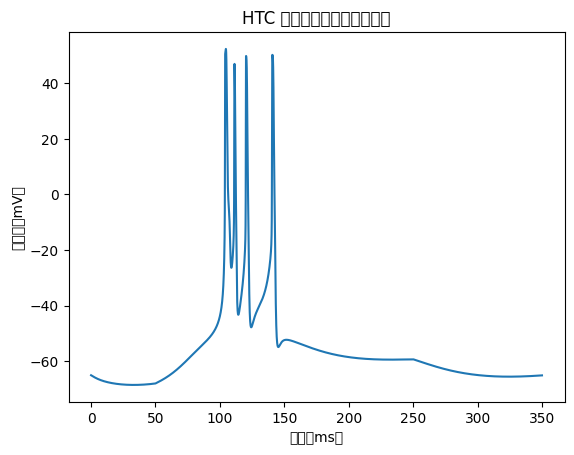

In [8]:
def try_trn_neuron():
    # 设置模拟时间步长
    brainstate.environ.set(dt=0.02 * u.ms)

    # 生成分段输入电流
    I = braintools.input.section_input(
        values=[0, 0.05, 0],  # 电流强度
        durations=[50 * u.ms, 200 * u.ms, 100 * u.ms]  # 各阶段持续时间
    ) * u.uA

    # 生成模拟时间序列
    times = u.math.arange(I.shape[0]) * brainstate.environ.get_dt()

    # 选择模拟的神经元类型（此处以 HTC 为例，可替换为 RTC、IN、TRN）
    neu = HTC(1, solver='ind_exp_euler')  # 使用独立指数欧拉法积分
    neu.init_state()  # 初始化神经元状态

    # 运行模拟并记录耗时
    t0 = time.time()
    vs = brainstate.compile.for_loop(neu.step_run, times, I)  # 循环更新神经元状态
    t1 = time.time()
    print(f"模拟耗时：{t1 - t0:.4f} 秒")  # 输出计算效率

    # 可视化膜电位变化
    plt.plot(
        times.to_decimal(u.ms),  # 横轴：时间
        u.math.squeeze(vs.to_decimal(u.mV))  # 纵轴：膜电位
    )
    plt.xlabel('时间（ms）')
    plt.ylabel('膜电位（mV）')
    plt.title('HTC 神经元对分段电流的响应')
    plt.show()


# 执行模拟
if __name__ == '__main__':
    try_trn_neuron()

## 结果解读

运行代码后，将得到 HTC 神经元在分段电流刺激下的膜电位变化曲线，典型特征如下：

0~50 ms（无电流）：神经元处于静息状态，膜电位稳定在约 -65 mV，由漏电流和 Ih 电流平衡维持。

50~250 ms（注入 0.05 uA 电流）：
   - 电流注入导致膜电位去极化，达到阈值后产生动作电位。
   - 由于 T 型钙通道和 IAHP 电流的作用，可能出现爆发式放电，这是丘脑神经元参与节律振荡的典型特征。

250~350 ms（电流关闭）：
   - 膜电位逐渐恢复静息水平，但可能因钙激活钾通道的持续作用出现超极化后电位。

## 扩展练习

- 替换神经元类型，如 ``neu = TRN(1)``，对比 TRN 与 HTC 对相同电流的响应差异。
- 修改 T 型钙通道电导，如 ``ICaT_HM1992(g_max=1.0 * ...)``，观察对神经元爆发式放电的影响。
- 延长模拟时间并分析不同丘脑神经元的自发节律特性。

通过这些实践，你将深入理解丘脑神经元的电生理特性及其在大脑节律调控中的作用。